# Preprocess HyperNeRF data to NSFF data style

In [38]:
import json
import numpy as np
import imageio
import pdb
from pathlib import Path
import cv2
import os
import shutil
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# @markdown The base directory for all captures. This can be anything if you're running this notebook on your own Jupyter runtime.
save_dir = './data/'  
capture_name = 'vrig-chicken' 
image_scale = 4
# The root directory for this capture.
root_dir = Path(save_dir, capture_name)
# Where to save RGB images.
rgb_dir = root_dir / 'rgb' / f'{image_scale}x'
# Where to save mask images.
camera_dir = root_dir / 'camera-gt'
mask_dir = root_dir / 'motion_masks'
mask_dir.mkdir(exist_ok=True)

if not camera_dir.exists():
    camera_dir = root_dir / 'camera'

with open(root_dir / 'metadata.json','r') as f:
    time_data = json.load(f)

with open(root_dir / 'dataset.json','r') as f:
    split_data = json.load(f)


rgb_list = list(sorted(rgb_dir.glob( '*.png')))
image_size = imageio.imread(rgb_list[0]).shape[:2]
image_size = np.array([image_size[1], image_size[0]])
cam_list = list(sorted(camera_dir.glob('*')))

target_image_dir = root_dir / 'images'
target_image_dir.mkdir(exist_ok=True)
for rgb in rgb_list:
    shutil.copy(str(rgb), str(target_image_dir))


# Save cameras

In [28]:
# read scene info
if (root_dir / 'scene_gt.json').exists():
    with open(root_dir / 'scene_gt.json','r') as f:
        scene_info = json.load(f)
else:
    with open(root_dir / 'scene.json','r') as f:
        scene_info = json.load(f)

near = scene_info['near'] / scene_info['scale']
far = scene_info['far'] / scene_info['scale']

# read camera info

c2w_mats = []
hwfs = []
bounds_mats = []
for i, rgb in enumerate(rgb_list):
    with open(camera_dir / f'{rgb.stem}.json','r') as f:
        camera_info = json.load(f)
    hwf = np.concatenate([camera_info['image_size'], [camera_info['focal_length']]]) / image_scale
    c2w_rot = np.array(camera_info['orientation']).T @ np.diag([1,-1,-1])
    c2w_trans = camera_info['position']

    c2w_mat = np.zeros([3,4])
    c2w_mat[:3,:3] = c2w_rot
    c2w_mat[:3,3] = c2w_trans
    # c2w_mat[3,3] = 1.
    c2w_mats.append(c2w_mat)
    hwfs.append(hwf[..., None])
    bounds_mats.append(np.array([near, far]))


c2w_mats = np.array(c2w_mats)
hwfs = np.array(hwfs).transpose([1,2,0])
poses = c2w_mats[:, :3, :4].transpose([1,2,0])
poses = np.concatenate([poses, hwfs], 1)

save_arr = []
for i in range((poses.shape[2])):
    save_arr.append(np.concatenate([poses[..., i].ravel(), bounds_mats[i]], 0))

save_arr = np.array(save_arr)


np.save(root_dir / 'poses_bounds_hn.npy', save_arr)

# Save masks -- NOT NEEDED!

Using cache found in /home/tw554/.cache/torch/hub/pytorch_vision_v0.10.0
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving t

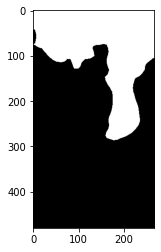

In [39]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# model.eval()

# def get_mask(filename):

#     input_image = Image.open(filename)
#     input_image = input_image.convert("RGB")
#     preprocess = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])

#     input_tensor = preprocess(input_image)
#     input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

#     # move the input and model to GPU for speed if available
#     if torch.cuda.is_available():
#         input_batch = input_batch.to('cuda')
#         model.to('cuda')

#     with torch.no_grad():
#         output = model(input_batch)['out'][0]
#     output_predictions = output.argmax(0)

#     return output_predictions.byte().cpu().numpy()


# # need to manually look at mask model output and choose the id of object to be masked out
# MASK_TARGET_ID = 15

# for img_path in rgb_list:
#     out = get_mask(str(img_path))
#     colmap_mask = np.where(out == MASK_TARGET_ID, 1., 0.)
#     colmap_mask = colmap_mask[..., None] * np.ones([1,3])
#     imageio.imsave(str(mask_dir / f'{img_path.stem}.png'), colmap_mask)


# plt.imshow(colmap_mask)